In [10]:
import requests
from datetime import datetime, timezone, timedelta
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
# Gloabl seaborn Theme
sns.set_theme(style="whitegrid", palette="pastel")
import math
import import_ipynb
from evaluation import to_timestamp, request_influxdb, query_data, histplots, boxplots, lineplots, evaluate_sensors


In [11]:
# Load Tangaras
tangaras = pd.read_csv('../data/tangaras.csv')
tangaras.shape

(22, 7)

In [12]:
# Start Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
#start_timestamp = to_timestamp('2023-03-17T00:00:00-05:00')
start_timestamp = to_timestamp('2023-04-03T00:00:00-05:00')
# End Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
#end_timestamp = to_timestamp('2023-03-31T00:00:00-05:00')
end_timestamp = to_timestamp('2023-04-04T00:00:00-05:00')

print(f'Since: {start_timestamp} Until: {end_timestamp}')


Since: 1680498000000 Until: 1680584400000


In [13]:
# Query Data Sensors
query = query_data(tangaras, start_timestamp, end_timestamp, datatype='tmp')
print(query)

SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0DD66') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE0E752') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE1260A') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE94B1A') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DE965F2') AND time >= 1680498000000ms AND time <= 1680584400000ms GROUP BY time(30s) fill(none); SELECT "name", last("tmp") FROM "fixed_stations_01" WHERE ("name" = 'D29ESP32DEBD89A') AND time >= 1680498000000ms AND time <= 168

In [14]:
# Get Data Frame Sensors
def df_sensors(tangaras, start_timestamp, end_timestamp):
    # Data Frame Sensors
    df_sensors = []
    # SQL Query Data Sensors
    query = query_data(tangaras, start_timestamp, end_timestamp, datatype='tmp')
    # InfluxDB API REST Request
    influxdb_request = request_influxdb(query)
    #print(influxdb_request)
    #print(influxdb_request.text)

    # Data Frame InfluxDB Sensors
    df_influxdb_sensors = pd.read_csv(StringIO(influxdb_request.text), sep=",", low_memory=False)

    # Remove/Add Columns
    df_influxdb_sensors = df_influxdb_sensors[['time', 'name.1', 'last']]
    df_influxdb_sensors.rename(columns={'time': 'DATETIME', 'name.1': 'MAC', 'last': 'TEMP'}, inplace=True)

    # Truncate Response
    for index, row in tangaras.iterrows():
        df_sensor = df_influxdb_sensors.loc[df_influxdb_sensors['MAC'] == row['MAC']].reset_index(drop=True)[['DATETIME', 'TEMP']] # Warning
        if not df_sensor.empty:
            df_sensor.rename(columns={'TEMP': row['ID']}, inplace=True)
            df_sensor.set_index('DATETIME', inplace=True)
            df_sensors.append(df_sensor)
    
    df_sensors = df_sensors[0].join(df_sensors[1:]).reset_index()

    # Date Time ISO 8601 Format, TZ='America/Bogota' -05:00
    tz = timezone(timedelta(hours=-5))
    df_sensors['DATETIME'] = df_sensors['DATETIME'].apply(lambda x: datetime.fromtimestamp(int(x) / 1000, tz=tz).isoformat())

    df_sensors[df_sensors.columns.to_list()[1:]] = df_sensors[df_sensors.columns.to_list()[1:]].astype('float64')
    
    return df_sensors


In [15]:
# Data Frame Sensors
temp_raw = df_sensors(tangaras, start_timestamp, end_timestamp)
temp_raw.head()

,DATETIME,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
0,2023-04-03T00:00:00-05:00,0.0,20.63,21.90,21.87,22.87,21.42,22.87,NaN,NaN,...,27.08,26.45,NaN,26.47,NaN,22.17,21.16,NaN,26.23,NaN
1,2023-04-03T00:00:30-05:00,0.0,20.61,NaN,21.86,22.91,21.39,22.88,26.44,29.32,...,27.06,26.43,28.37,26.47,25.48,NaN,NaN,26.4,26.23,26.70
2,2023-04-03T00:01:00-05:00,0.0,20.60,21.86,21.86,NaN,21.42,22.88,26.39,29.32,...,27.05,26.40,28.33,26.47,25.38,22.17,21.19,26.4,26.25,26.68
3,2023-04-03T00:01:30-05:00,0.0,20.58,21.84,21.87,22.88,21.42,22.87,26.44,29.30,...,27.05,26.41,28.28,26.46,25.41,22.17,21.16,26.4,26.26,26.76
4,2023-04-03T00:02:00-05:00,0.0,20.55,21.86,21.86,22.87,21.42,22.87,26.45,29.29,...,27.05,26.40,28.24,26.47,25.47,22.18,21.18,26.4,26.25,26.80


# Descriptive Statistics

In [17]:
# Describe Data
temp_raw.describe()

,TANGARA_DD66,TANGARA_E752,TANGARA_260A,TANGARA_4B1A,TANGARA_65F2,TANGARA_D89A,TANGARA_1106,TANGARA_1282,TANGARA_14D6,TANGARA_1A1E,...,TANGARA_2852,TANGARA_2B42,TANGARA_2E9A,TANGARA_2FF6,TANGARA_375E,TANGARA_F212,TANGARA_1712,TANGARA_48C6,TANGARA_F1AE,TANGARA_06BE
count,2653.0,2571.000000,2550.000000,2560.000000,2552.000000,2563.000000,2555.000000,2640.000000,2598.000000,2165.000000,...,2614.000000,2540.000000,2634.000000,2648.000000,2588.000000,2568.000000,2565.000000,2627.000000,2625.000000,2620.000000
mean,0.0,26.990424,25.750231,28.016102,26.436869,26.891385,27.686630,29.635629,31.477410,31.398305,...,31.372621,28.199630,31.436317,30.612311,30.700429,28.222562,27.311906,30.335364,29.718819,30.738088
std,0.0,5.206480,3.204808,5.100265,3.016896,4.815466,4.266698,3.316419,2.668429,4.991732,...,4.276745,2.381614,2.815938,3.857031,5.416481,4.830060,5.043808,4.086051,3.353837,3.524562
min,0.0,20.380000,21.410000,21.390000,22.400000,20.950000,22.460000,25.020000,28.300000,25.720000,...,25.450000,25.370000,27.890000,25.820000,23.980000,22.020000,20.780000,25.000000,25.300000,25.890000
25%,0.0,21.120000,22.080000,22.090000,23.070000,21.630000,23.070000,26.357500,28.770000,26.370000,...,26.370000,25.890000,28.720000,26.360000,24.900000,22.750000,21.540000,26.100000,25.990000,26.840000
50%,0.0,27.130000,26.050000,28.480000,26.830000,26.460000,27.380000,29.210000,31.795000,29.540000,...,31.150000,28.190000,30.940000,30.020000,29.900000,28.580000,27.790000,30.100000,29.840000,30.460000
75%,0.0,31.155000,28.670000,32.310000,28.980000,30.660000,31.435000,32.282500,33.945000,36.460000,...,35.890000,29.600000,33.180000,34.110000,34.910000,32.170000,31.470000,33.700000,32.660000,33.880000
max,0.0,35.850000,30.570000,36.240000,31.160000,35.450000,35.020000,36.540000,36.210000,42.440000,...,37.850000,35.850000,38.240000,38.240000,42.170000,36.290000,35.430000,38.200000,35.280000,36.590000


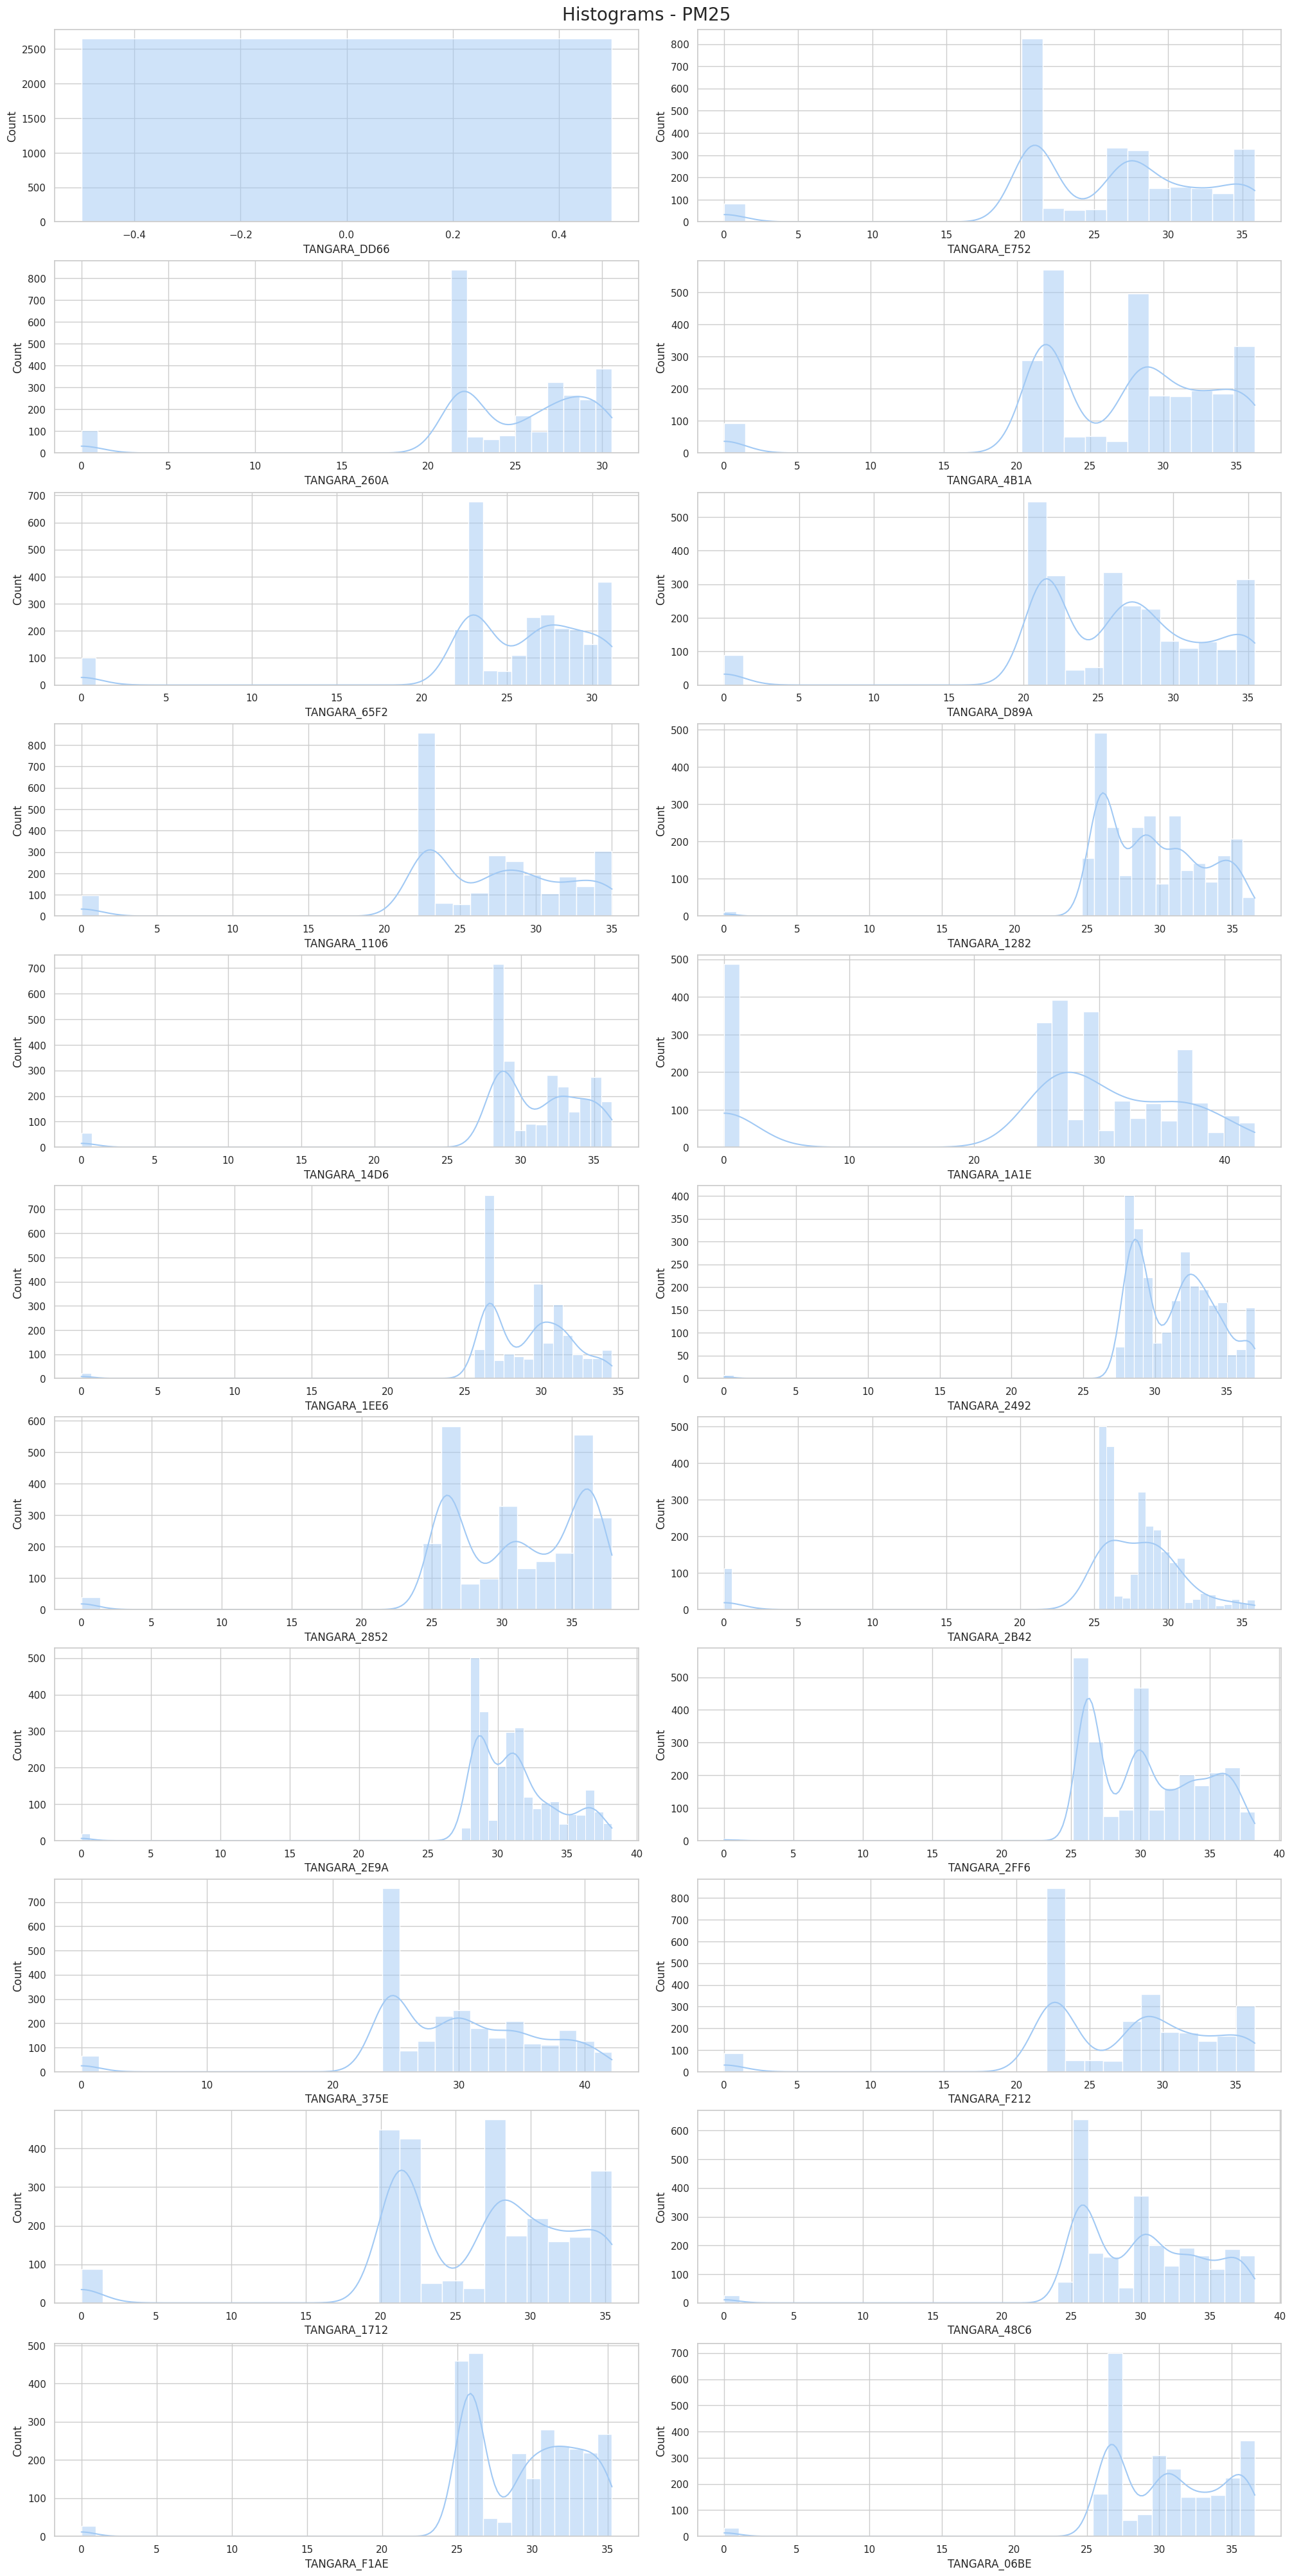

In [18]:
# Plot Temperature Histograms
histplots(temp_raw)

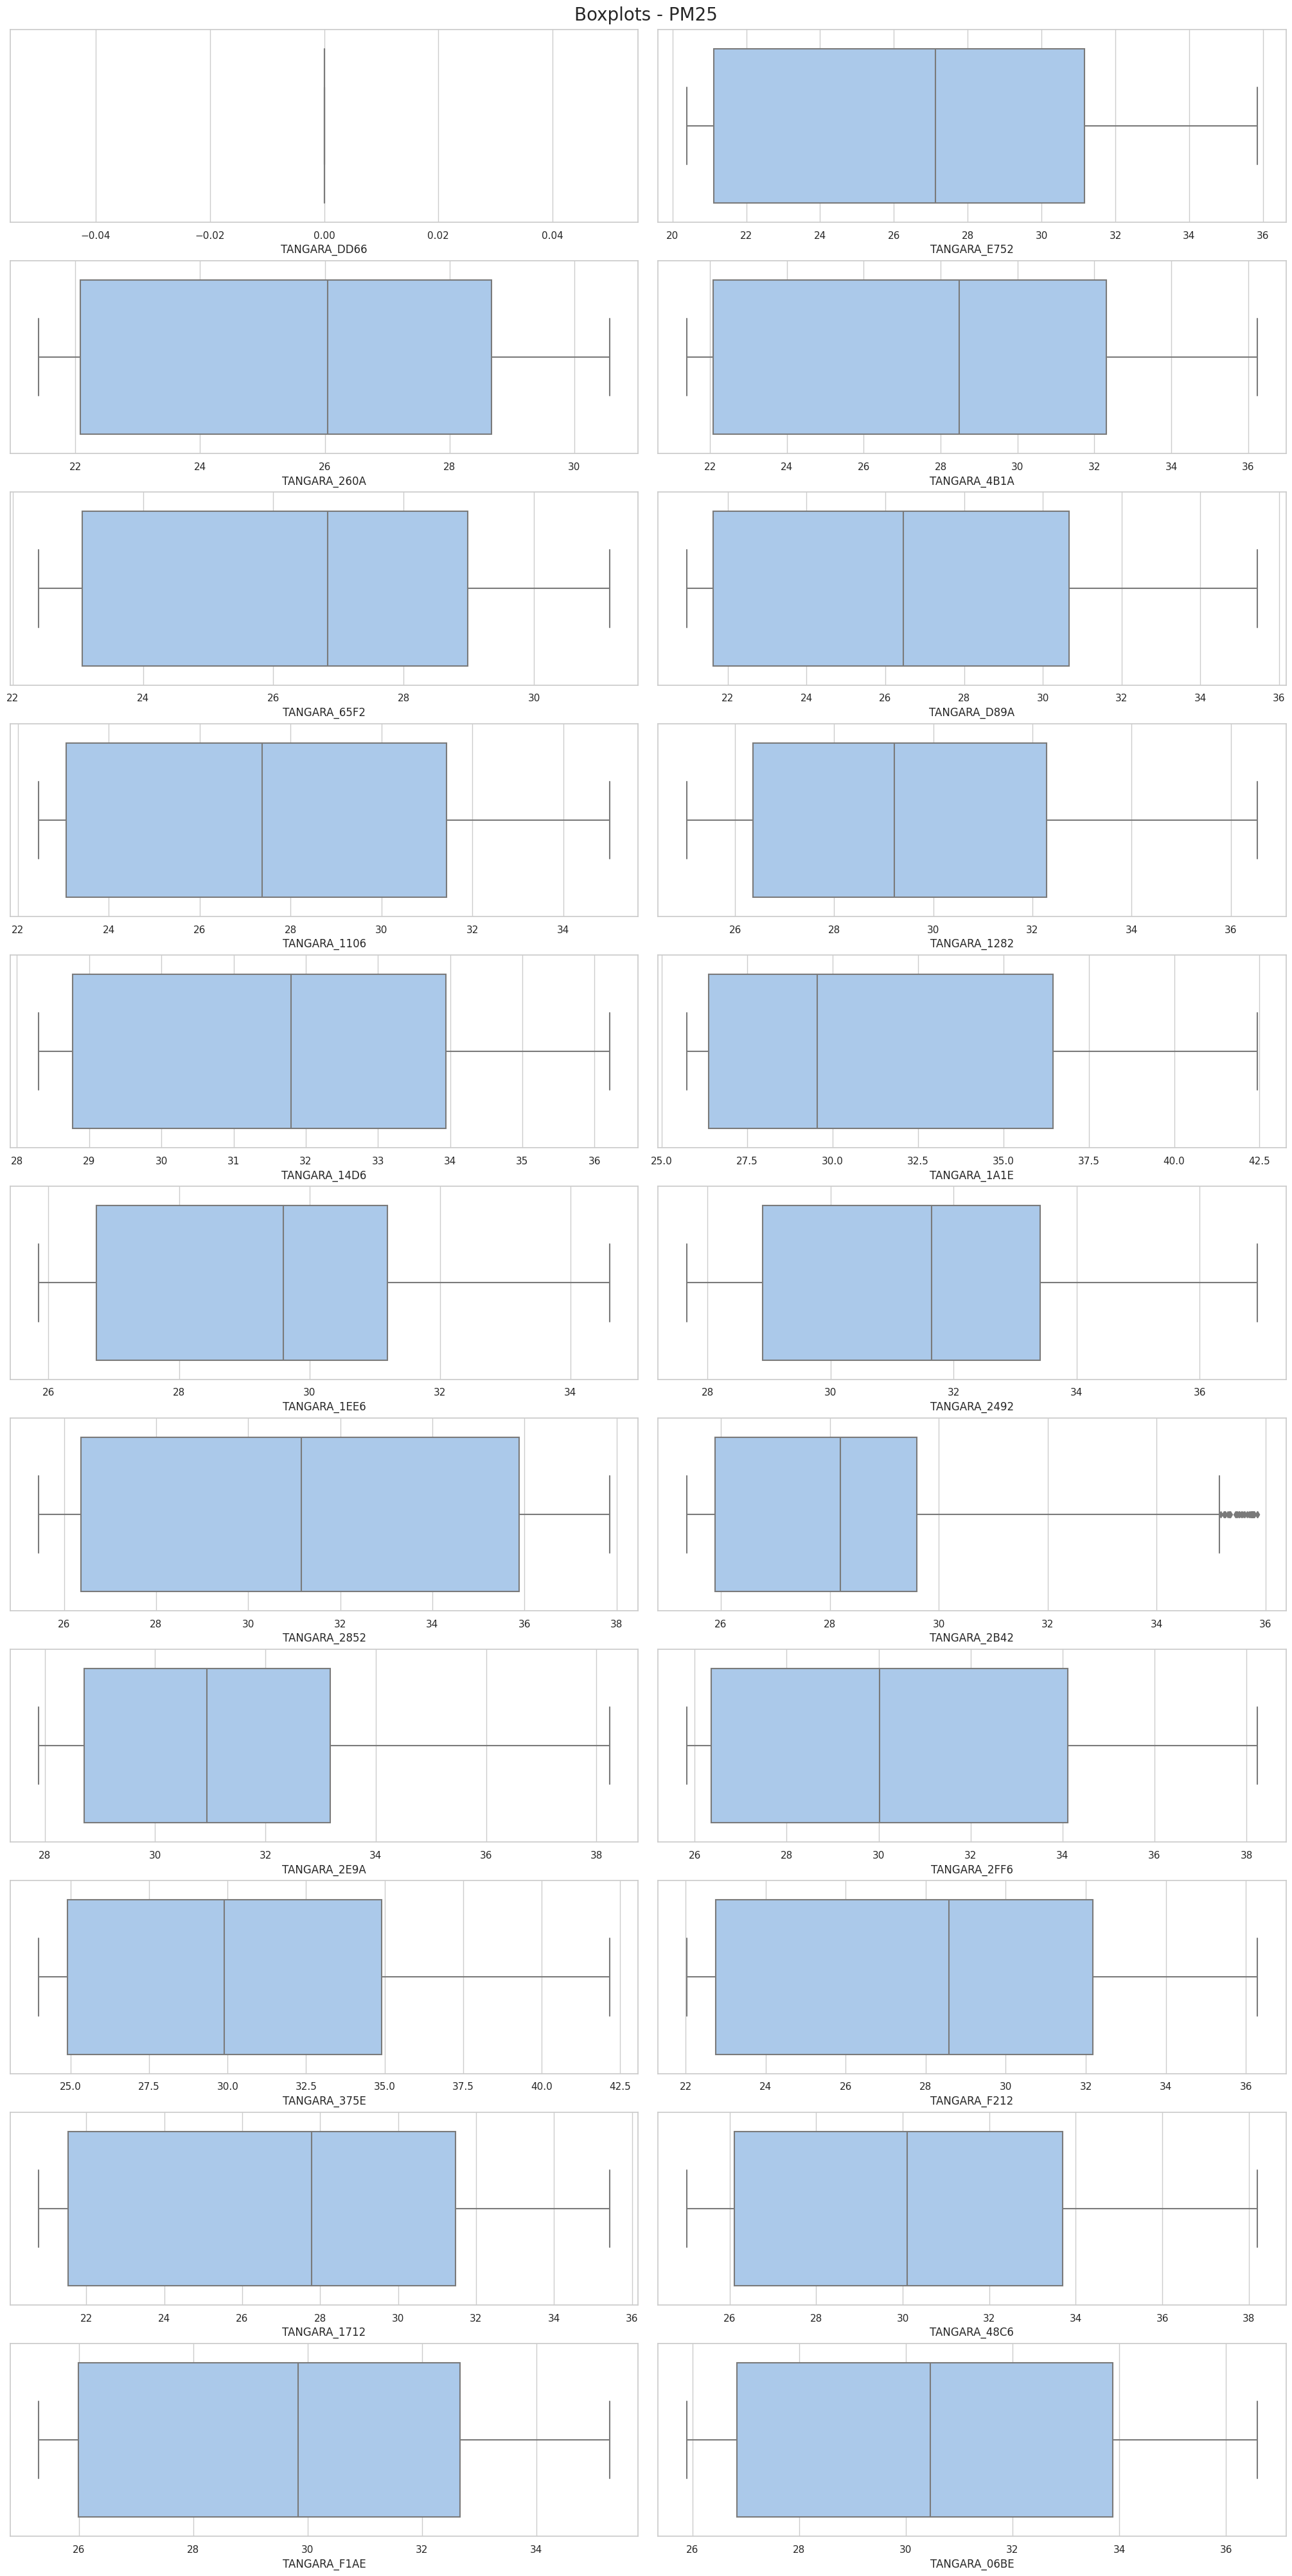

In [19]:
# Plot Temperature Boxplots
boxplots(temp_raw)

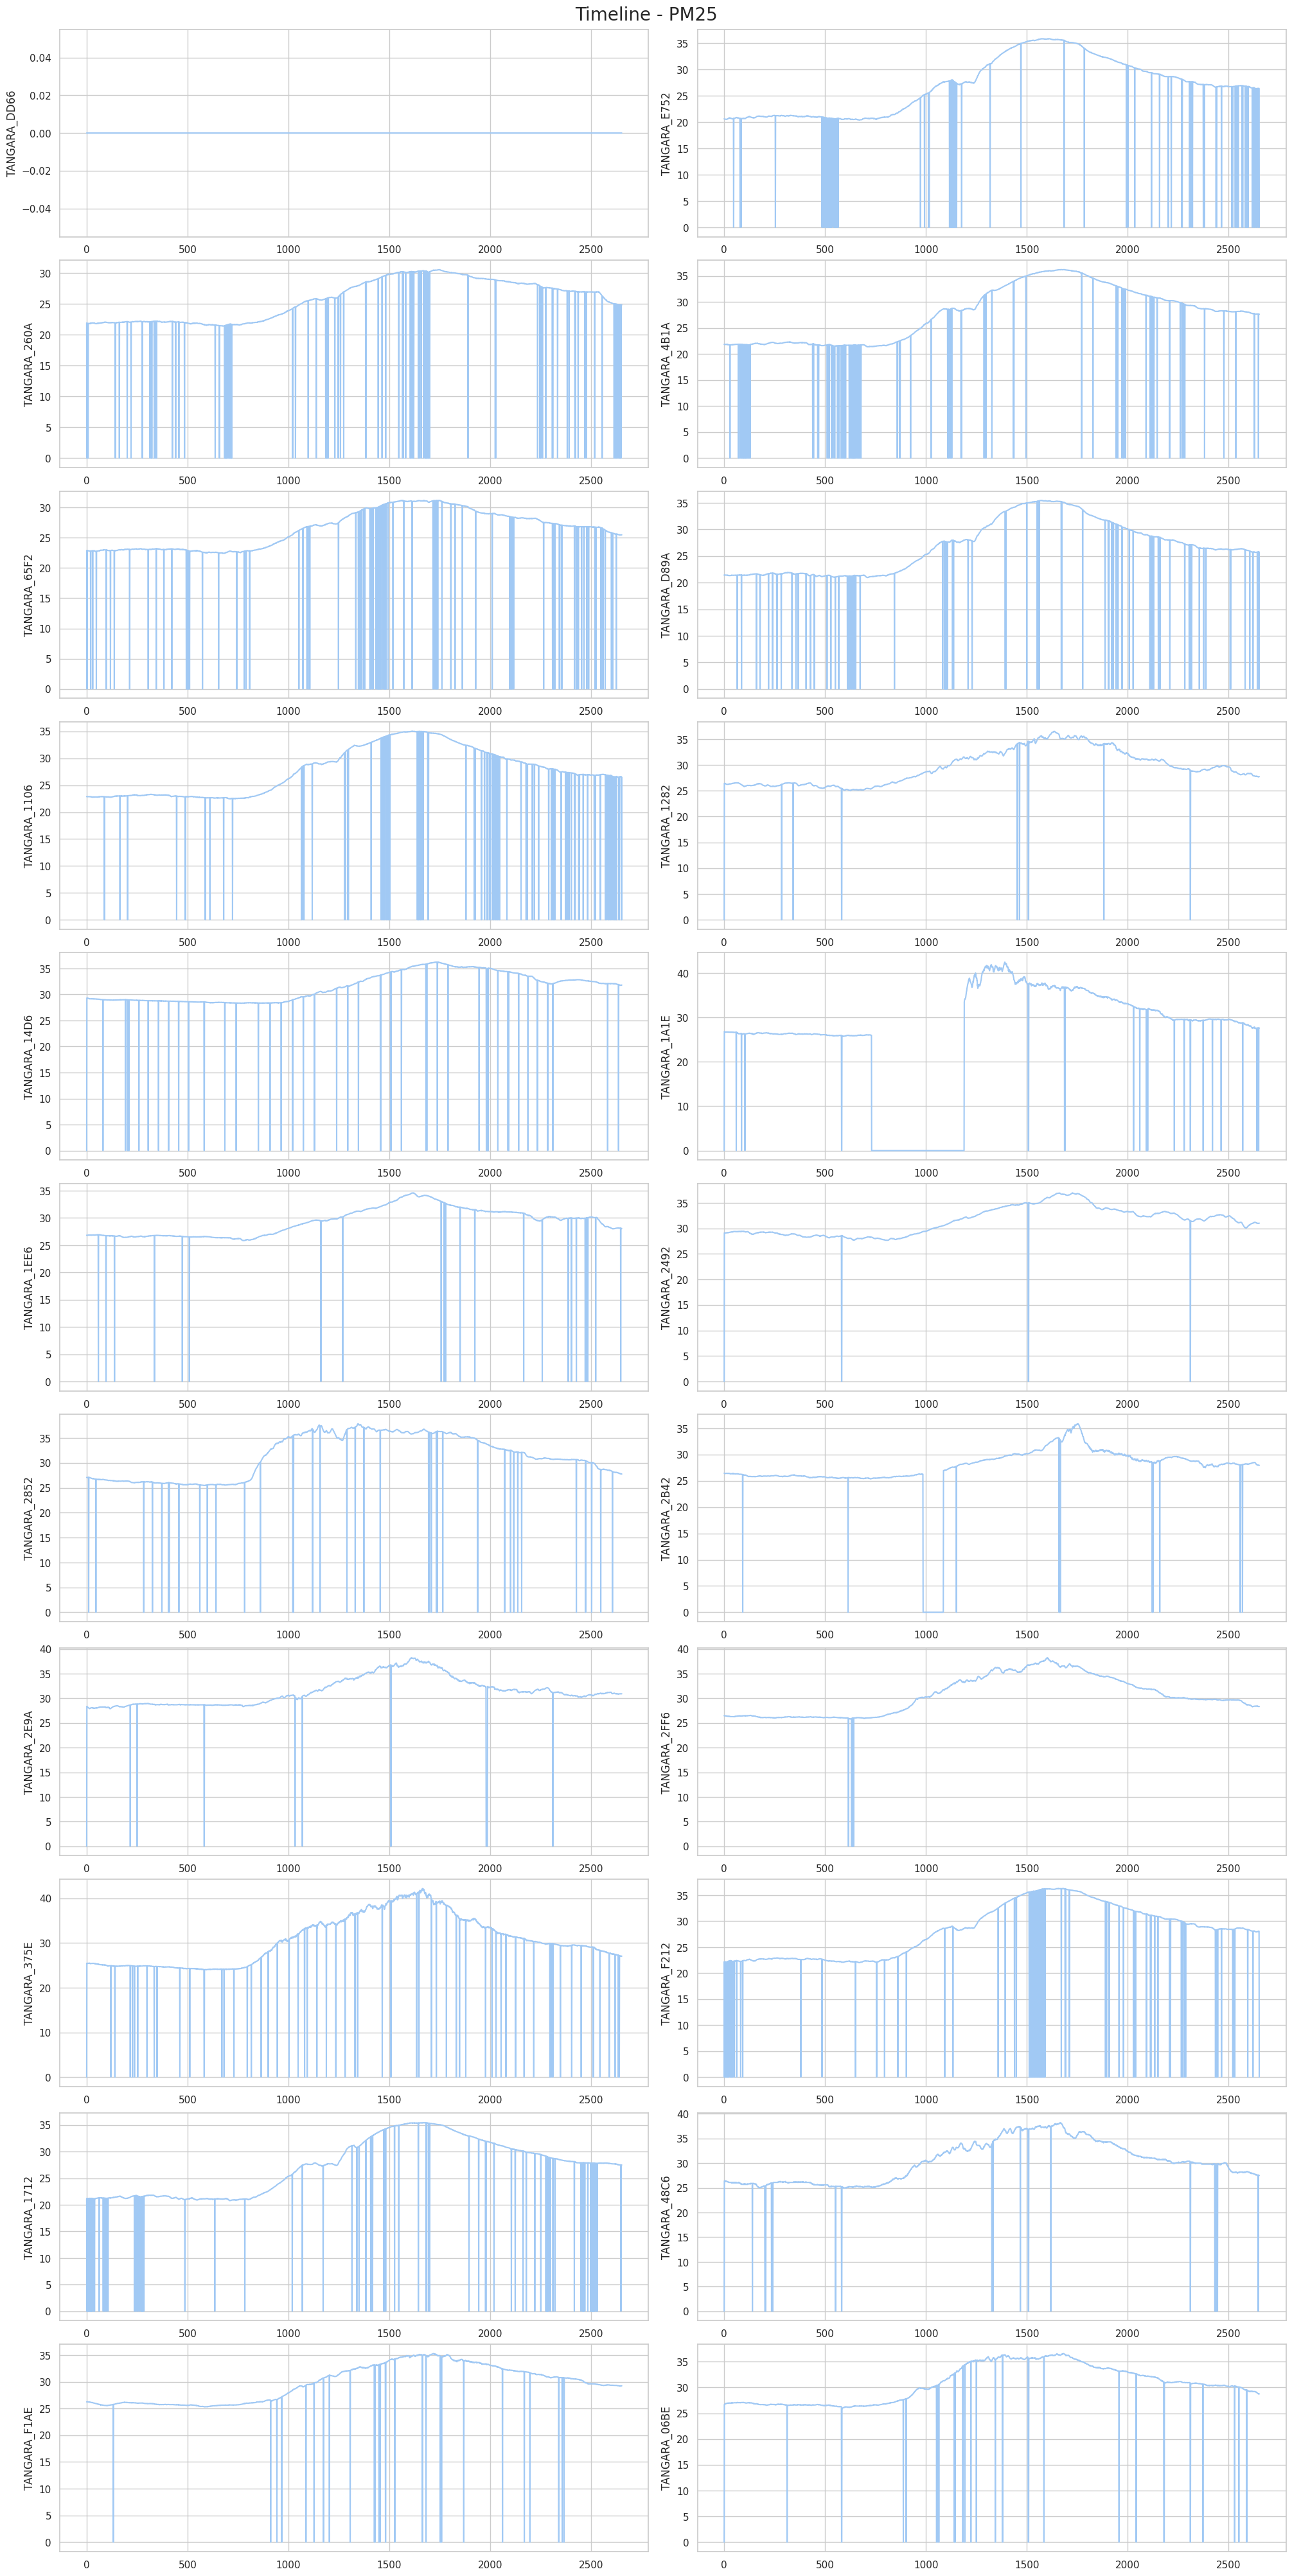

In [20]:
# Plot Temperature Lineplots
lineplots(temp_raw)

In [21]:
# Evaluate Sensors
print(f'Total Sensors: {len(temp_raw.columns[1:])}')
to_be_checked = evaluate_sensors(temp_raw, 85)
print(f'To Be Checked: {len(to_be_checked)}')
to_be_checked

Total Sensors: 22
To Be Checked: 1


[{'ID': 'TANGARA_1A1E', 'Data': '82%', 'Missing': '18%'}]

In [16]:
# Save Temperature raw data into CSV file
temp_raw.to_csv('../data/temp_raw.csv', index=False)